In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv, dotenv_values
import os
import datetime
import alpaca
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.option import OptionHistoricalDataClient, OptionLatestQuoteRequest
from alpaca.data.historical.stock import StockHistoricalDataClient, StockTradesRequest, StockBarsRequest
from alpaca.trading.client import TradingClient, GetAssetsRequest
from alpaca.trading.requests import GetOptionContractsRequest, LimitOrderRequest, MarketOrderRequest, GetOrdersRequest
from alpaca.trading.enums import AssetStatus, ContractType, OrderSide, OrderType, TimeInForce, QueryOrderStatus

In [2]:
# Load Alpaca API keys
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
paper = True

In [3]:
# Initiate Alpaca clients
def get_alpaca_data(ticker1,ticker2,lookback):
    
    # Set start and end dates
    stock_data_client = StockHistoricalDataClient(api_key=alpaca_api_key, secret_key=alpaca_secret_key)
    option_data_client = OptionHistoricalDataClient(api_key=alpaca_api_key, secret_key=alpaca_secret_key)
    delta = datetime.timedelta(days=lookback)
    start=datetime.datetime.today() - delta
    end=datetime.datetime.today()


    # Fetch stock data for our two stocks
    request_params = StockBarsRequest(
        symbol_or_symbols=f"{ticker1},{ticker2}",
        start=start,
        end=end,
        timeframe=TimeFrame(1,TimeFrameUnit.Day),
        adjustment='all'
    )

    data = stock_data_client.get_stock_bars(request_params=request_params)
    
    return start,end,data

# Set variables for request data
ticker1 = "XOM"
ticker2 = "CVX"
lookback = 600
start, end, data = get_alpaca_data(ticker1,ticker2,lookback)

In [4]:
# Create separate dataframes for tickers
ticker1_data = data[ticker1]
ticker2_data = data[ticker2]
ticker1_df = pd.DataFrame([(t.close,t.volume,t.timestamp) for t in ticker1_data],columns=['close','volume','datetime'])
ticker2_df = pd.DataFrame([(t.close,t.volume,t.timestamp) for t in ticker2_data],columns=['close','volume','datetime'])

# Create separate columns for data and time
ticker1_df['date'] = ticker1_df['datetime'].dt.date
ticker2_df['date'] = ticker2_df['datetime'].dt.date
#ticker1_df['time'] = ticker1_df['datetime'].dt.time
#ticker2_df['time'] = ticker2_df['datetime'].dt.time
ticker1_df = ticker1_df.drop('datetime', axis=1)
ticker2_df = ticker2_df.drop('datetime',axis=1)

# Join both dataframes into one
df = ticker1_df.join(ticker2_df, lsuffix=f'_{ticker1}', rsuffix=f'_{ticker2}')
df = df.drop(f'date_{ticker1}',axis=1)
df.rename(columns={f'date_{ticker2}':'date'}, inplace=True)
print(df)

     close_XOM  volume_XOM  close_CVX  volume_CVX        date
0        96.77  12927831.0     141.56   6396080.0  2023-12-22
1        96.99  16835144.0     142.83   5165588.0  2023-12-26
2        96.53  14558830.0     142.36   5337244.0  2023-12-27
3        95.13  16329252.0     140.36   8147993.0  2023-12-28
4        94.94  17746408.0     139.79   7658638.0  2023-12-29
..         ...         ...        ...         ...         ...
404     106.51  15321811.0     152.78   7840914.0  2025-08-06
405     105.95  13468287.0     153.16   6510670.0  2025-08-07
406     106.80  14417734.0     155.01   6332807.0  2025-08-08
407     105.83  13570661.0     153.45   6169716.0  2025-08-11
408     106.13  14109418.0     154.44   6641593.0  2025-08-12

[409 rows x 5 columns]


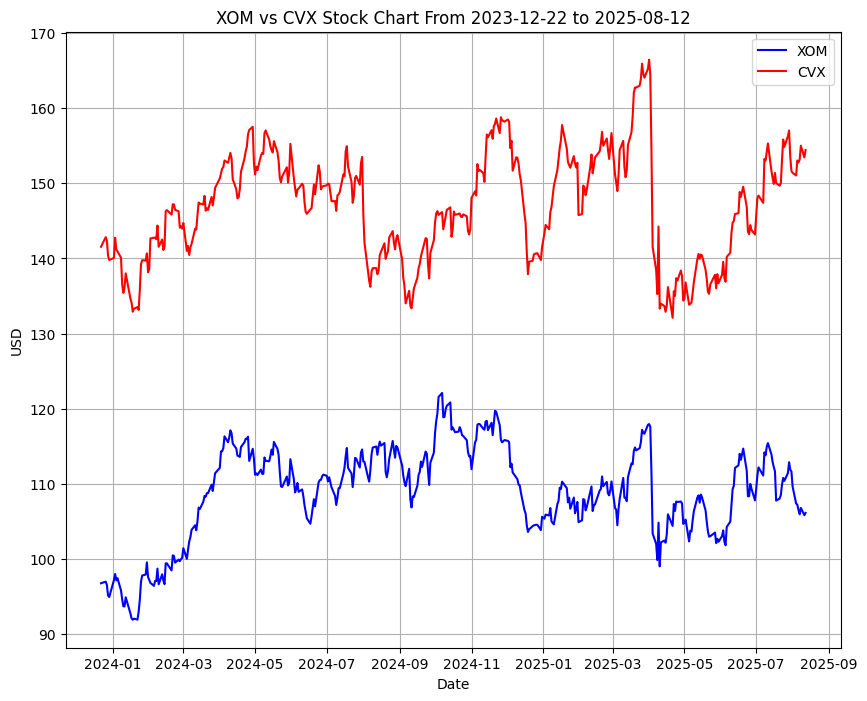

In [5]:
# Plot stock chart
plt.figure(figsize=(10,8))
plt.plot(df["date"], df[f'close_{ticker1}'], color='blue', label=ticker1)
plt.plot(df["date"], df[f'close_{ticker2}'], color="red", label=ticker2)
plt.title(f"{ticker1} vs {ticker2} Stock Chart From {df['date'][0]} to {df['date'][df.index[-1]]}")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Calculate daily daily returns
daily_returns = df[[f'close_{ticker1}',f'close_{ticker2}']].pct_change().dropna()

# Calculate the correlation coefficient
correlation = daily_returns[f'close_{ticker1}'].corr(daily_returns[f'close_{ticker2}'])
print(correlation)

0.8063730256338341


In [7]:
from statsmodels.tsa.stattools import coint

# Cointegration test
score, p_value, critical_values = coint(df[f'close_{ticker1}'], df[f'close_{ticker2}'])

print(f"Cointegration test p-value: {p_value}")
if p_value <= 0.05:
    print(f"The stock prices of {ticker1} and {ticker2} are likely cointegrated.")
else:
    print(f"The stock prices of {ticker1} and {ticker2} are likely not cointegrated.")



Cointegration test p-value: 0.472183677945056
The stock prices of XOM and CVX are likely not cointegrated.


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Normalize stock data using MinMax
scaler = MinMaxScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df[[f'close_{ticker1}',f'close_{ticker2}']]), columns=[ticker1,ticker2])
df_norm['date'] = df['date']
df_norm

,XOM,CVX,date
0,0.160702,0.275400,2023-12-22
1,0.167992,0.312373,2023-12-26
2,0.152750,0.298690,2023-12-27
3,0.106362,0.240466,2023-12-28
4,0.100066,0.223872,2023-12-29
...,...,...,...
404,0.483433,0.602038,2025-08-06
405,0.464877,0.613100,2025-08-07
406,0.493042,0.666958,2025-08-08
407,0.460901,0.621543,2025-08-11


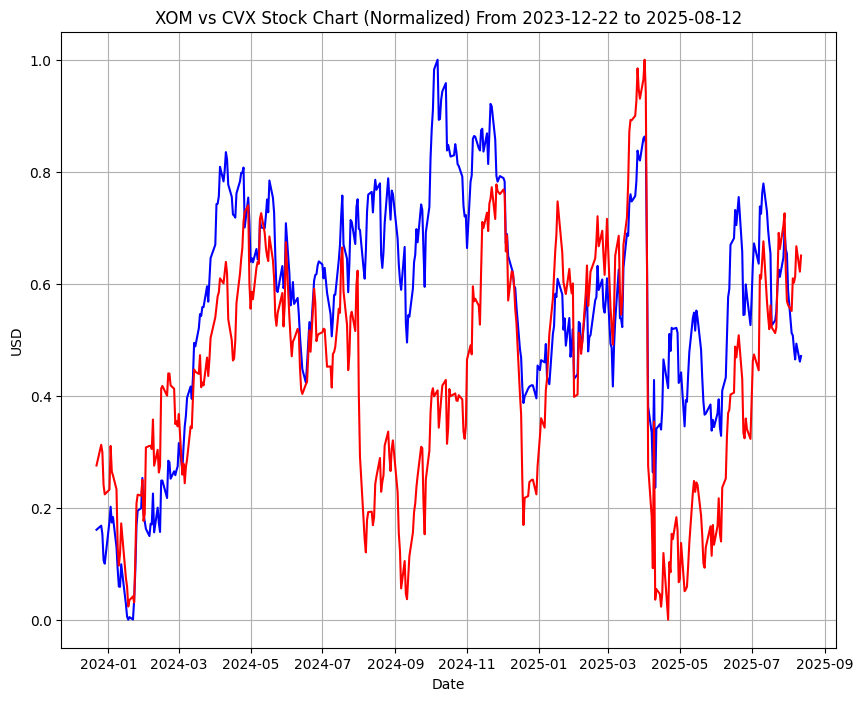

In [9]:
# Plot normalized stock data
plt.figure(figsize=(10,8))
plt.plot(df["date"], df_norm[ticker1], color='blue')
plt.plot(df["date"], df_norm[ticker2], color="red")
plt.title(f"{ticker1} vs {ticker2} Stock Chart (Normalized) From {df['date'][0]} to {df['date'][df.index[-1]]}")
plt.xlabel("Date")
plt.ylabel("USD")
plt.grid(True)
plt.show()

In [10]:
df_norm['spread'] = df_norm[ticker1] - df_norm[ticker2]

# Use expanding mean and std for dynamic thresholds
df_norm['spread_mean'] = df_norm['spread'].expanding().mean()
df_norm['spread_std'] = df_norm['spread'].expanding().std()

# Calculate thresholds based on expanding statistics
df_norm['sd_pos'] = df_norm['spread_mean'] + 1.5 * df_norm['spread_std']
df_norm['sd_neg'] = df_norm['spread_mean'] - 1.5 * df_norm['spread_std']

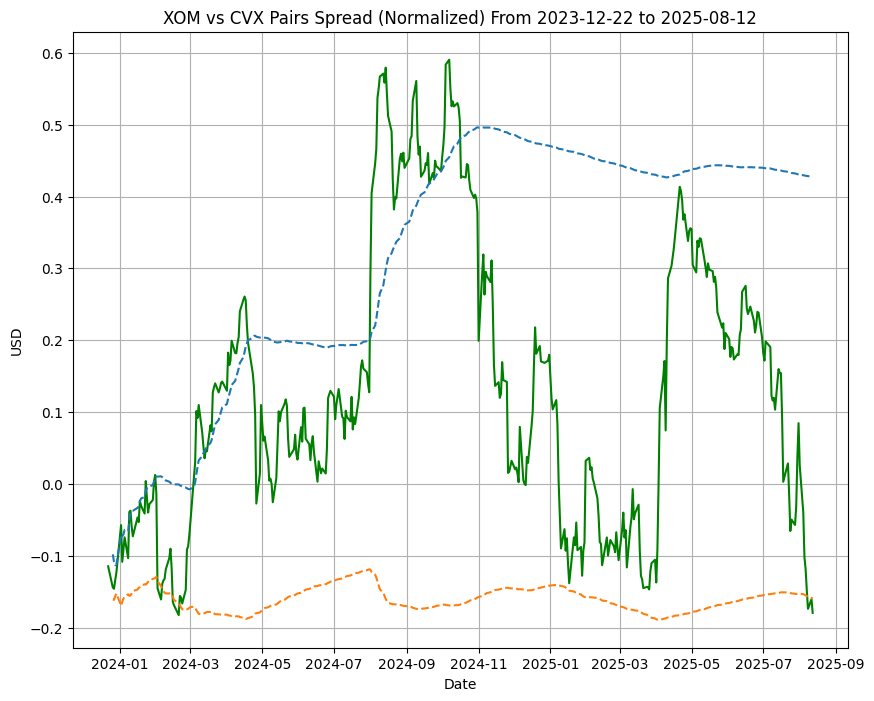

In [11]:
# Plot the normalized spread between each stock
plt.figure(figsize=(10,8))
#plt.plot(df["date"], df_norm['XOM'], color='blue')
#plt.plot(df["date"], df_norm["CVX"], color="red")
plt.plot(df['date'], df_norm['spread'], color="green")
#plt.axhline(y=df_norm['spread'].mean(),linestyle='--', label='mean')

# Plot the signal lines
plt.plot(df['date'], df_norm['sd_pos'], linestyle='--', label='Pos. SD')
plt.plot(df['date'], df_norm['sd_neg'], linestyle='--', label='Neg. SD')
plt.title(f"{ticker1} vs {ticker2} Pairs Spread (Normalized) From {df['date'][0]} to {df['date'][df.index[-1]]}")
plt.xlabel("Date")
plt.ylabel("USD")
plt.grid(True)
plt.show()

In [12]:
# Create signal column to identify strategy for each day
df_norm['signal'] = 0
df_norm.loc[df_norm['spread'] > df_norm['sd_pos'], 'signal'] = 1
df_norm.loc[df_norm['spread'] < df_norm['sd_neg'], 'signal'] = -1
df_norm.loc[df_norm['spread'].abs() < df_norm['sd_pos'], 'signal'] = 0  
df_norm

,XOM,CVX,date,spread,spread_mean,spread_std,sd_pos,sd_neg,signal
0,0.160702,0.275400,2023-12-22,-0.114698,-0.114698,NaN,NaN,NaN,0
1,0.167992,0.312373,2023-12-26,-0.144381,-0.129539,0.020989,-0.098056,-0.161023,0
2,0.152750,0.298690,2023-12-27,-0.145940,-0.135006,0.017605,-0.108599,-0.161413,0
3,0.106362,0.240466,2023-12-28,-0.134104,-0.134781,0.014381,-0.113209,-0.156352,0
4,0.100066,0.223872,2023-12-29,-0.123806,-0.132586,0.013387,-0.112505,-0.152666,0
...,...,...,...,...,...,...,...,...,...
404,0.483433,0.602038,2025-08-06,-0.118605,0.136868,0.194656,0.428851,-0.155115,0
405,0.464877,0.613100,2025-08-07,-0.148223,0.136166,0.194929,0.428560,-0.156228,0
406,0.493042,0.666958,2025-08-08,-0.173916,0.135404,0.195295,0.428346,-0.157538,0
407,0.460901,0.621543,2025-08-11,-0.160642,0.134678,0.195605,0.428085,-0.158729,0


In [13]:
# Create backtester for strategy
initial_cash = 100000
cash = initial_cash
df_norm['cash'] = 0.0
df_norm['total'] = 0.0
num_exits = 0
num_longs = 0
num_shorts = 0
ticker1_pos = 0
ticker2_pos = 0

for i in range(1, len(df_norm)):
    ticker1_price = df[f'close_{ticker1}'].iloc[i]
    ticker2_price = df[f'close_{ticker2}'].iloc[i]
    prev_signal = df_norm['signal'].iloc[i-1]
    curr_signal = df_norm['signal'].iloc[i]
    cash *= 1 + (0.04 / 365)
    
    

    # Exit position
    if curr_signal == 0 and prev_signal != 0:
        cash += abs(ticker1_pos) * ticker1_price + abs(ticker2_pos) * ticker2_price
        ticker1_pos = 0
        ticker2_pos = 0
        num_exits += 1
        

    # Enter long spread: long ticker1, short ticker2
    elif curr_signal == 1 and prev_signal == 0: 
        ticker1_pos = (0.5 * cash) // ticker1_price
        ticker2_pos = ((0.5 * cash) // ticker2_price) * -1
        cash -= (abs(ticker1_pos) * ticker1_price + abs(ticker2_pos) * ticker2_price)
        num_longs += 1
        

    # Enter short spread: short ticker1, long ticker2
    elif curr_signal == -1 and prev_signal == 0:
        ticker1_pos = ((0.5 * cash) // ticker1_price) * -1
        ticker2_pos = (0.5 * cash) // ticker2_price
        cash -= (abs(ticker1_pos) * ticker1_price + abs(ticker2_pos) * ticker2_price)
        num_shorts += 1

    df_norm.loc[df_norm.index[i], 'ticker1_pos'] = ticker1_pos
    df_norm.loc[df_norm.index[i], 'ticker2_pos'] = ticker2_pos
    df_norm.loc[df_norm.index[i], 'cash'] = cash
    df_norm.loc[df_norm.index[i], 'total'] = cash + abs(ticker1_pos) * ticker1_price + abs(ticker2_pos) * ticker2_price

print(f"Number of long spread trades: {num_longs}")
print(f"Number of short spread trades: {num_shorts}")
print(f"Number of exits: {num_exits}")

Number of long spread trades: 9
Number of short spread trades: 2
Number of exits: 11


In [14]:
# Calculate final portofolio value and total return
final_value = df_norm['total'].iloc[-1]
returns = (final_value - initial_cash) / initial_cash
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Return: {returns * 100:.2f}%")

Final Portfolio Value: $115,607.60
Total Return: 15.61%


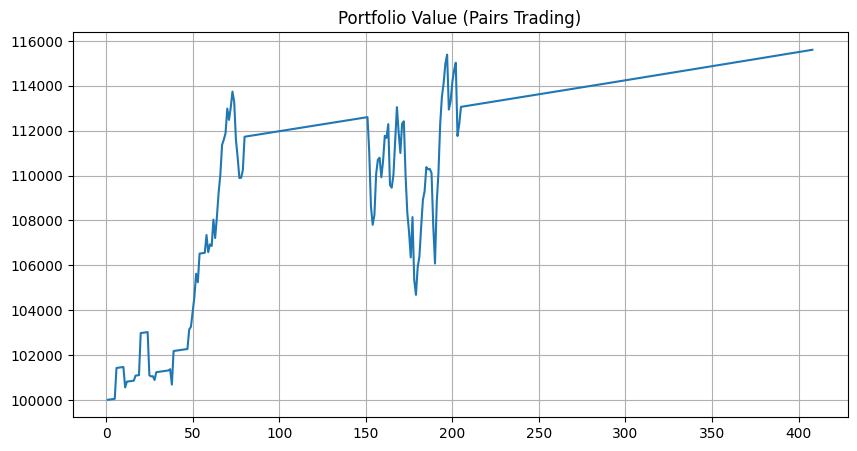

In [15]:
# Plot portfolio value over backtest period
df_norm['total'][1:].plot(title='Portfolio Value (Pairs Trading)', figsize=(10, 5))
plt.grid(True)
plt.show()

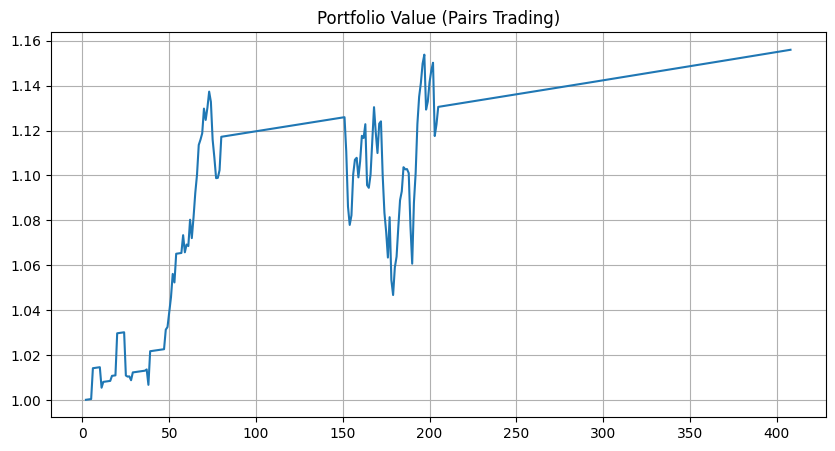

In [16]:
# Calculate daily return and cumulative return
df_norm['daily_return'] = df_norm[['total']][1:].pct_change().dropna()
df_norm['tot_return'] = (1 + df_norm[['total']][1:].pct_change()).cumprod()

df_norm['tot_return'].plot(title='Portfolio Value (Pairs Trading)', figsize=(10, 5))
plt.grid(True)
plt.show()